# Binary Image Classification: Galaxy vs Star
This notebook trains a CNN to classify images as either galaxies or stars using **PyTorch**.

## 1. Import Libraries

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import time

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Common parameters
img_height = 64
img_width = 64
batch_size = 32
data_dir = "images"

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device count: 1
Using device: cuda


## 2. Load and Prepare Data
Load images from the folder structure. PyTorch will use folder names as labels.

In [3]:
# Define transforms and create datasets
transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # ensure 1-channel input
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ]
)

# Consider converting images to greyscale in above section

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Train/val/test split (70/15/15)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total images: {total_size}")
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

Classes: ['galaxy', 'star']
Total images: 3986
Train: 2790, Val: 597, Test: 599


## 3. Visualize Sample Images

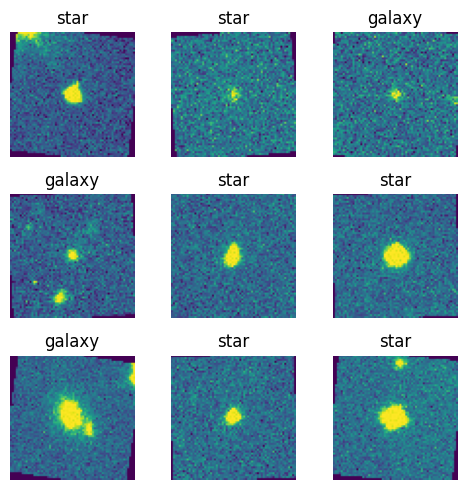

In [4]:
# Display 9 sample images
plt.figure(figsize=(5, 5))
# Take one batch from the training loader
images, labels = next(iter(train_loader))
for i in range(min(9, images.size(0))):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Make CNN

In [5]:
# Define the CNN model in PyTorch
embedding_count = 8

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(  # Consider only input layer for grayscale
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 3 -> 1
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, embedding_count),  # <-- embedding layer
            nn.ReLU(),
            nn.Linear(embedding_count, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def embed(self, x):
        """Return 128‑dim feature embedding for each image."""
        x = self.features(x)
        x = self.classifier[0](x)  # Flatten
        x = self.classifier[1](x)  # Linear(…, embedding_count)
        x = self.classifier[2](x)  # ReLU
        return x

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=8, bias=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=2, bias=True)
  )
)


## 5. Train the model

In [6]:
epochs = 20
train_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []
epoch_times = []

for epoch in range(epochs):
    epoch_start = time.time()

    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total if total > 0 else 0
    train_acc = running_correct / total if total > 0 else 0

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels_all = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy().tolist())
            val_labels_all.extend(labels.cpu().numpy().tolist())
    val_acc = val_correct / val_total if val_total > 0 else 0
    if val_total > 0:
        val_f1 = f1_score(val_labels_all, val_preds, average="binary")
    else:
        val_f1 = 0.0

    epoch_time = time.time() - epoch_start
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    epoch_times.append(epoch_time)

    print(
        f"Epoch {epoch+1}/{epochs} - ",
        f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, ",
        f"Val acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Time: {epoch_time:.2f}s"
    )

total_training_time = sum(epoch_times)
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/20 -  Train loss: 0.5713, Train acc: 0.7480,  Val acc: 0.7956, Val F1: 0.8862, Time: 99.42s
Epoch 2/20 -  Train loss: 0.5523, Train acc: 0.7566,  Val acc: 0.7956, Val F1: 0.8860, Time: 8.85s
Epoch 3/20 -  Train loss: 0.5285, Train acc: 0.7527,  Val acc: 0.7923, Val F1: 0.8828, Time: 10.42s
Epoch 4/20 -  Train loss: 0.5020, Train acc: 0.7581,  Val acc: 0.8023, Val F1: 0.8883, Time: 10.05s
Epoch 5/20 -  Train loss: 0.4428, Train acc: 0.7828,  Val acc: 0.8040, Val F1: 0.8854, Time: 8.03s
Epoch 6/20 -  Train loss: 0.3952, Train acc: 0.8219,  Val acc: 0.8593, Val F1: 0.9143, Time: 10.05s
Epoch 7/20 -  Train loss: 0.3770, Train acc: 0.8369,  Val acc: 0.8576, Val F1: 0.9151, Time: 9.85s
Epoch 8/20 -  Train loss: 0.3750, Train acc: 0.8427,  Val acc: 0.8543, Val F1: 0.9146, Time: 6.92s
Epoch 9/20 -  Train loss: 0.3544, Train acc: 0.8480,  Val acc: 0.8526, Val F1: 0.9130, Time: 9.12s
Epoch 10/20 -  Train loss: 0.3535, Train acc: 0.8498,  Val acc: 0.8794, Val F1: 0.9281, Time: 9.73s
Epoch

## 6. Collect embeddings

In [7]:
import numpy as np

def collect_embeddings(dataloader):
    model.eval()
    all_embeds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeds = model.embed(images)  # [batch, 128]
            all_embeds.append(embeds.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_embeds), np.concatenate(all_labels)

## 7. Visualize embedding

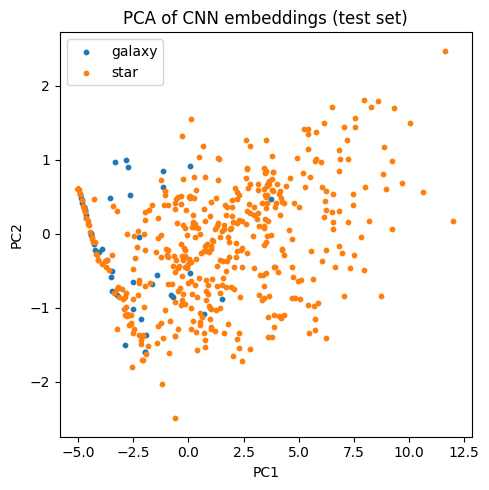

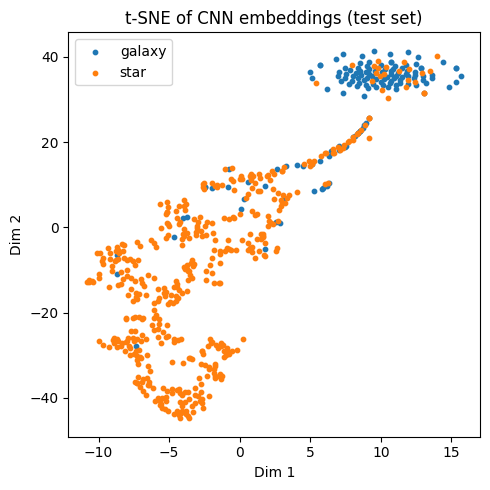

In [8]:
# 7. Visualize embedding
# Visualize embeddings with PCA / t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embeds, labels = collect_embeddings(test_loader)

# PCA
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeds)

# t-SNE
tsne = TSNE(n_components=2, init="random", learning_rate="auto")
embeds_tsne = tsne.fit_transform(embeds)

# --- PCA plot ---
plt.figure(figsize=(5, 5))
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(embeds_pca[mask, 0], embeds_pca[mask, 1], s=10, label=class_names[c])
plt.legend()
plt.title("PCA of CNN embeddings (test set)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# --- t-SNE plot ---
plt.figure(figsize=(5, 5))
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(embeds_tsne[mask, 0], embeds_tsne[mask, 1], s=10, label=class_names[c])
plt.legend()
plt.title("t-SNE of CNN embeddings (test set)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

## 8. Linear probe

In [9]:
# To test quality of embedding

# 8. Linear probe with logistic regression on CNN embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Collect embeddings for each split
X_train, y_train = collect_embeddings(train_loader)
X_val,   y_val   = collect_embeddings(val_loader)
X_test,  y_test  = collect_embeddings(test_loader)

# Logistic regression = linear probe
probe = LogisticRegression(max_iter=1000)
probe.fit(X_train, y_train)

# Evaluate
for name, X, y in [("Train", X_train, y_train),
                   ("Val",   X_val,   y_val),
                   ("Test",  X_test,  y_test)]:
    y_pred = probe.predict(X)
    acc = accuracy_score(y, y_pred)
    f1  = f1_score(y, y_pred, average="binary")
    print(f"{name}  -  acc: {acc:.4f}, f1: {f1:.4f}")

Train  -  acc: 0.8986, f1: 0.9323
Val  -  acc: 0.8995, f1: 0.9371
Test  -  acc: 0.8915, f1: 0.9279


## 9. Encoding and Ansatz

c:\Users\samsn\anaconda3\envs\qiskit_env\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:272: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\samsn\anaconda3\envs\qiskit_env\Lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(


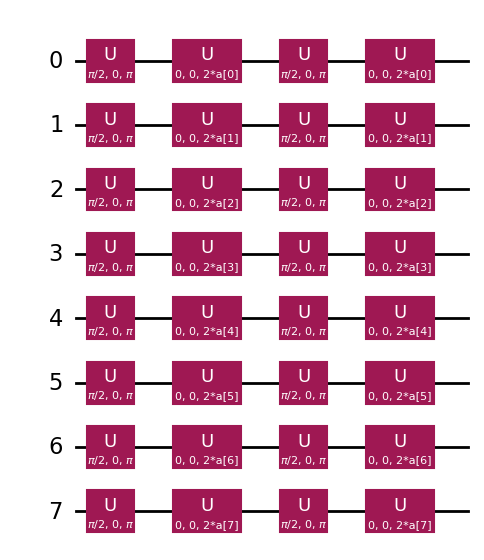

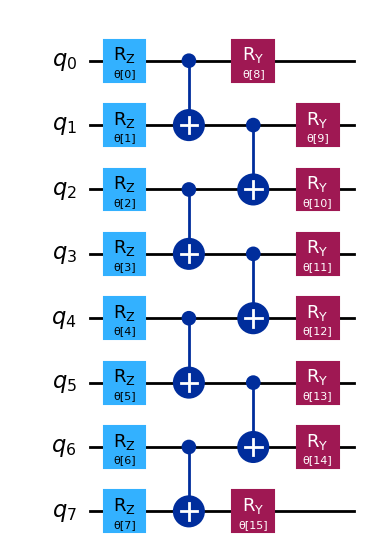

In [ ]:
from qiskit.circuit.library import z_feature_map
from qiskit import QuantumCircuit
from qiskit.circuit.library import efficient_su2
from qiskit.circuit import ParameterVector
 
# One qubit per data feature
num_qubits = embedding_count

# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = z_feature_map(num_qubits, parameter_prefix="a")
fig = feature_map.decompose(reps=1).draw("mpl", scale=1)
display(fig)

# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(embedding_count)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * embedding_count)

# A first variational layer:
for i in range(embedding_count):
    qnn_circuit.rz(params[i], i) # ry

# # Entangling layer:
# # 3 CNOTs for qubits 0–3: (0->1), (1->2), (2->3)
# for control in range(0, 3):
#     target = control + 1
#     qnn_circuit.cx(control, target)                     # Simple Ansatz

# # 3 CNOTs for qubits 4–7: (4->5), (5->6), (6->7)
# for control in range(4, 7):
#     target = control + 1
#     qnn_circuit.cx(control, target)

# # Entangling layer: 
# for control in range(embedding_count - 1):                 # fully sequential
#     target = control + 1
#     qnn_circuit.cx(control, target)

# Entangling layer: alternating pattern
# First layer: (0-1), (2-3), (4-5), (6-7)
for control in range(0, embedding_count - 1, 2):
    qnn_circuit.cx(control, control + 1)                 # Alternating ansatz

# Second layer: (1-2), (3-4), (5-6)
for control in range(1, embedding_count - 1, 2):
    qnn_circuit.cx(control, control + 1)

# The second variational layer:
for i in range(embedding_count):
    qnn_circuit.ry(params[embedding_count + i], i) # rx

# # Use EfficientSU2 as the variational ansatz
# qnn_circuit = efficient_su2(
#     num_qubits=embedding_count,
#     reps=1,                 # increase for deeper ansatz
#     entanglement="linear",  # or "full", "circular", etc.
# )

# Draw the circuit
qnn_circuit.draw("mpl")

## 10. Combine

15
2+ qubit depth (combined): 7


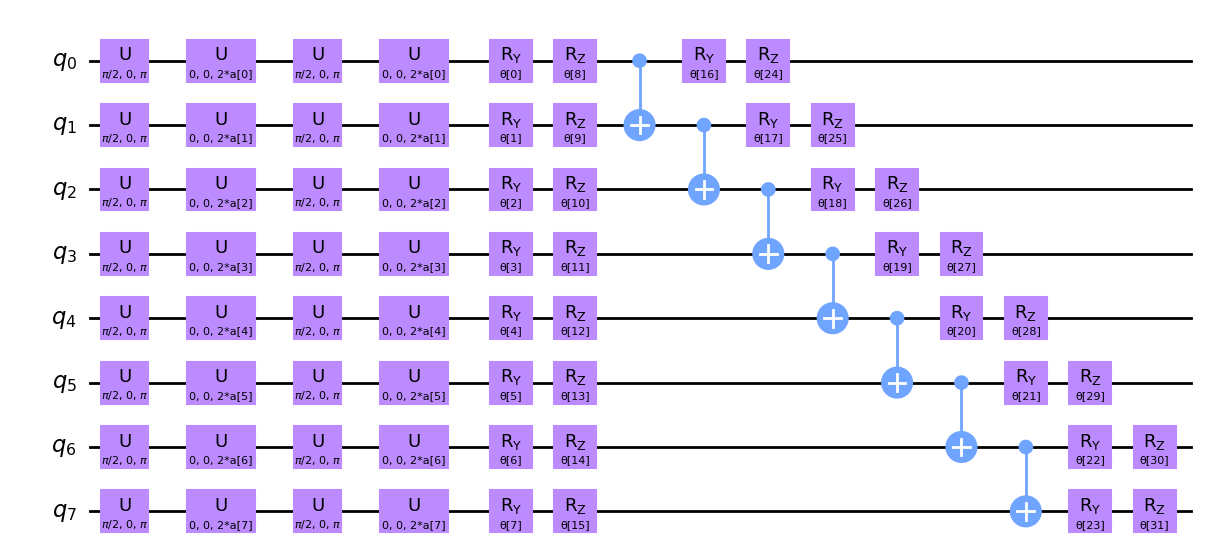

In [13]:
# QNN ansatz
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Check the combined circuit depth, and the two-qubit gate depth
print(full_circuit.decompose().depth())
print(
    f"2+ qubit depth (combined): "
    f"{full_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

## 12. Optimize for quantum execution

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_torino


In [15]:
from qiskit.circuit.library import XGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
target = backend.target

observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

# Transpiled depths
print("Transpiled depth:", circuit_ibm.depth())
print(
    "Transpiled 2+ qubit depth:",
    circuit_ibm.depth(lambda instr: len(instr.qubits) > 1),
)

Transpiled depth: 40
Transpiled 2+ qubit depth: 7


## 13. Execute

In [16]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator


# Globals for the QNN
circuit = full_circuit
observables = observable
estimator = Estimator()  # statevector simulator
objective_func_vals = []

def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
 
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.
 
    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
 
    return expectation_values

def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.
 
    weight_params: ansatz parameters to be updated by the optimizer.
 
    output: MSE loss.
    """
    global iteration

    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )
 
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
 
    print(f"Iter: {iteration}, loss: {cost}")
    iteration += 1
 
    return cost

def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).
 
    prediction: predictions from the forward pass of neural network.
    target: true labels.
 
    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
num_epochs = 1

X_train, y_train = collect_embeddings(train_loader)
input_params = X_train
target = y_train.astype(float)

qnn_train_start = time.time()  # <-- add this

for epoch in range(num_epochs):

    # optional: reset iteration counter per batch
    iteration = 0

    res = minimize(
        mse_loss_weights,
        weight_params,
        method="COBYLA",
        options={"maxiter": 100}
    )
    weight_params = res["x"]

# After training finishes, print total time
qnn_total_time = time.time() - qnn_train_start
print(f"Total QNN training time: {qnn_total_time:.2f} seconds")


Iter: 0, loss: 0.7020526333267033
Iter: 1, loss: 0.7062401060330183
Iter: 2, loss: 0.6595756716521382
Iter: 3, loss: 0.7259123383652242
Iter: 4, loss: 0.6719558610522703
Iter: 5, loss: 0.6512021197716502
Iter: 6, loss: 0.6350720887630876
Iter: 7, loss: 0.6475217163701641
Iter: 8, loss: 0.6667708218542356
Iter: 9, loss: 0.6282816328487807
Iter: 10, loss: 0.6452326316440731
Iter: 11, loss: 0.686747207293034
Iter: 12, loss: 0.6261681031447048
Iter: 13, loss: 0.6013835764362995
Iter: 14, loss: 0.5997674866077511
Iter: 15, loss: 0.60758347444284
Iter: 16, loss: 0.5988248115190583
Iter: 17, loss: 0.5068403287223622
Iter: 18, loss: 0.6348555065525868
Iter: 19, loss: 1.0330570108242036
Iter: 20, loss: 0.49969102410634847
Iter: 21, loss: 0.532647598932655
Iter: 22, loss: 0.5043890065861821
Iter: 23, loss: 0.6115074872025918
Iter: 24, loss: 0.6863607172899886
Iter: 25, loss: 0.49969102410634847
Iter: 26, loss: 0.49969102410634847
Iter: 27, loss: 0.4996910241063484
Iter: 28, loss: 0.4996910241063

## 14. Test

### Train data

In [20]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
# Use CNN embeddings and labels collected earlier
pred_train = forward(circuit, X_train, res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, X_train, res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = 0
print(pred_train_labels)
print(y_train)
 
accuracy = accuracy_score(y_train, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

f1 = f1_score(y_train, pred_train_labels, average="binary")
print(f"Train F1 score: {f1:.4f}")

[0.5103377  0.67343259 0.80008579 ... 0.47242966 0.57748314 0.6342136 ]
[1. 1. 1. ... 1. 1. 1.]
[1 0 1 ... 1 1 1]
Train accuracy: 76.84587813620072%
Train F1 score: 0.8691


### Test data

In [21]:
# ...existing code...
pred_test = forward(circuit, X_test, res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, X_test, res["x"], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = 0
print(pred_test_labels)
print(y_test)

accuracy = accuracy_score(y_test, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

f1 = f1_score(y_test, pred_test_labels, average="binary")
print(f"Test F1 score: {f1:.4f}")

[0.57592723 0.63738395 0.68600144 0.6872043  0.72457608 0.60258619
 0.51389796 0.63809011 0.63811661 0.60511409 0.56666405 0.62023226
 0.71095806 0.55953255 0.56666405 0.68840278 0.64205    0.60170118
 0.65798465 0.63265127 0.55310107 0.56666405 0.62645673 0.60970511
 0.66687277 0.60232332 0.55749777 0.63783585 0.63784887 0.66342851
 0.57508306 0.70789743 0.77353411 0.64887692 0.56286054 0.63376375
 0.60227933 0.57157599 0.62343621 0.56898216 0.65919222 0.63091034
 0.54919134 0.47985593 0.52375901 0.49888658 0.56666405 0.57389542
 0.62347156 0.76845998 0.68624384 0.53955522 0.62882657 0.56547601
 0.51483562 0.63470092 0.56666405 0.64561772 0.53369767 0.63696086
 0.59430119 0.55480711 0.73346247 0.69316153 0.63557897 0.66204309
 0.60684956 0.53398345 0.66058829 0.69918686 0.53884192 0.56498102
 0.62797335 0.64669579 0.66490656 0.56135071 0.66411119 0.63733382
 0.6216626  0.56666405 0.5971066  0.57412341 0.6811207  0.57151987
 0.6901721  0.56666405 0.57908879 0.56666405 0.498292   0.5521

## 15. Convergence

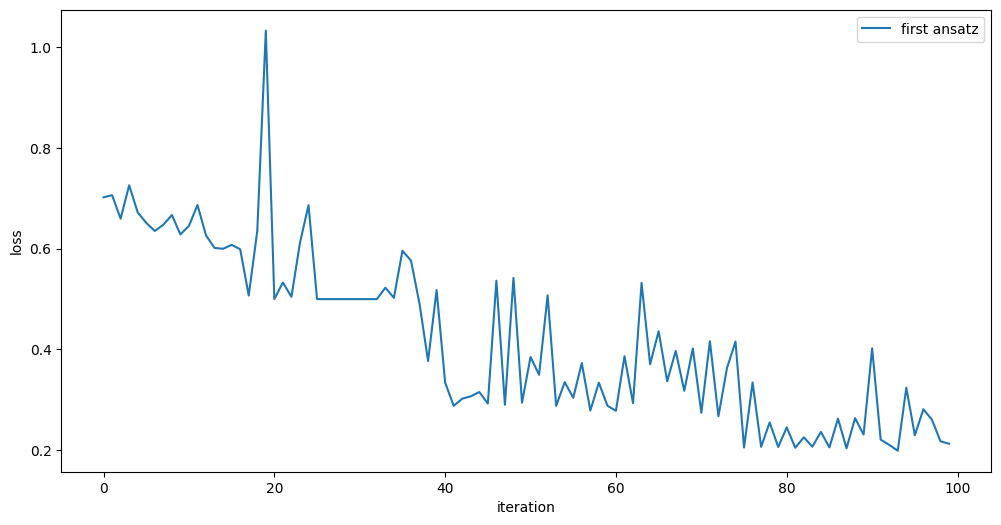

In [19]:
obj_func_vals_first = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()